In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

!pip install pmdarima
from pmdarima import auto_arima



# This will help to eliminate some irritating warnings
pd.options.mode.copy_on_write = True

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 23.6 MB/s eta 0:00:0000:0100:01
/kaggle/input/sharadar-etfs/sharadar/SFP.csv/SHARADAR_SFP_2_fb4f5d2244276f3cfeca03f46b122d99.csv
/kaggle/input/sharadar-etfs/sharadar/TICKERS.csv/SHARADAR_TICKERS_2_7ef16c1ffc4112bb028c13f3e3743955.csv
/kaggle/input/sharadar-etfs/sharadar/ACTIONS.csv/SHARADAR_ACTIONS_2_d1d74f09961f5a075917e43ce5da531e.csv


In [3]:
tb = pd.read_csv("/kaggle/input/sharadar-etfs/sharadar/SFP.csv/SHARADAR_SFP_2_fb4f5d2244276f3cfeca03f46b122d99.csv")

    

In [4]:
# This code isn't pretty, but it is thousands of times faster than the 
# easy-to-read alternative that calculates log return by ticker
tb = tb.sort_values(by=["ticker", "date"])
tb["revenue"] = tb["close"] * tb["volume"]
tb["return"] = tb["closeadj"] / tb["closeadj"].shift()
tb["tickeryesterday"] = tb["ticker"].shift()
tb["logreturn"] = np.log(tb["closeadj"] / tb["closeadj"].shift())
tb.loc[tb["ticker"] != tb["tickeryesterday"], "return"] = np.nan
tb.drop("tickeryesterday", axis=1, inplace=True)

In [5]:
tb.head()

,ticker,date,open,high,low,close,volume,closeadj,closeunadj,lastupdated,revenue,return,logreturn
5430274,AAA,2020-09-09,25.10,25.119,25.070,25.070,17327.0,22.617,25.070,2024-02-04,434387.89,NaN,NaN
5430273,AAA,2020-09-10,25.06,25.070,25.046,25.068,23485.0,22.615,25.068,2024-02-04,588721.98,0.999912,-0.000088
5430272,AAA,2020-09-11,25.04,25.050,25.020,25.035,33362.0,22.585,25.035,2024-02-04,835217.67,0.998673,-0.001327
5430271,AAA,2020-09-14,25.01,25.060,25.010,25.020,13146.0,22.572,25.020,2024-02-04,328912.92,0.999424,-0.000576
5430270,AAA,2020-09-15,25.02,25.030,25.010,25.010,12069.0,22.563,25.010,2024-02-04,301845.69,0.999601,-0.000399


In [6]:
def tickers_by_revenue(ltb):
    stickers = ltb.groupby("ticker")["revenue"].sum().sort_values(ascending=False).index.to_list()
    return stickers



In [7]:
n_base_etfs = 200
n_model_etfs = 16

window_size = 1250
skip_size = 20

first_train_data_date = "2002-01-01"
first_val_data_date = "2019-01-01"
first_test_data_date = "2023-01-01"
first_eval_data_date = "2024-01-01"




In [8]:
def gen_ts_vectors(stb, tickers):
    vs = []
    for t in tickers:
        v = stb.loc[stb["ticker"] == t, ["date", "logreturn"]]
        v = v.set_index("date", drop=True)
        vs.append(v)
    
    rv = pd.concat(vs, axis=1)
    rv.columns = tickers
    return rv


In [9]:
tb_train = tb[(tb["date"] >= first_train_data_date) & (tb["date"] < first_val_data_date)]

In [10]:
train_tickers = tickers_by_revenue(tb_train)[0:20]

train_endog = gen_ts_vectors(tb_train, train_tickers)


In [11]:
train_endog.head()

,SPY,QQQ,IWM,EEM,XLF,DIA,XLE,GLD,EFA,EWZ,FXI,TLT,VXX1,SDS,OIH,GDX,IVV,IYR,MDY,VWO
date,,,,,,,,,,,,,,,,,,,,
2002-01-02,0.010709,0.030354,0.004662,NaN,-0.001180,0.010973,-0.007568,NaN,0.005828,0.020257,NaN,NaN,NaN,NaN,-0.046131,NaN,0.010438,0.005578,0.000000,NaN
2002-01-03,0.011272,0.034083,0.018325,NaN,0.006791,0.010838,-0.006041,NaN,0.008299,0.025202,NaN,NaN,NaN,NaN,-0.016095,NaN,0.011191,0.003110,0.012746,NaN
2002-01-04,0.006649,0.004067,0.008688,NaN,0.013178,0.007806,0.004534,NaN,0.006590,-0.007624,NaN,NaN,NaN,NaN,0.019353,NaN,0.006826,-0.000111,0.007738,NaN
2002-01-07,-0.007078,-0.011082,-0.016219,NaN,-0.002586,-0.006831,-0.000343,NaN,-0.013224,-0.010641,NaN,NaN,NaN,NaN,0.007838,NaN,-0.007675,-0.002610,-0.006047,NaN
2002-01-08,-0.002318,0.006760,0.011681,NaN,-0.013936,-0.003922,-0.008746,NaN,-0.010852,-0.004619,NaN,NaN,NaN,NaN,-0.020583,NaN,-0.004305,-0.001614,-0.000526,NaN


In [12]:
train_endog[np.isnan(train_endog)] = 0

In [29]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.utils import check_random_state
from sklearn.metrics import mean_squared_error
import pandas as pd

class GBVARMAX:
    """
    Gradient Boosting Vector Autoregressive Moving Average with eXogeneous Variables

    This class implements a Gradient Boosting algorithm for regression with 
    lagged dependent variables. It supports 
    multiple output variables and includes features such as:

    - **Lagged dependent variables:** Incorporates past values of the target 
      variables as features.
    - **Lagged prediction errors:** Uses past prediction errors as features.
    - **Validation split:** Enables automatic splitting of data for model 
      evaluation during training.

    Parameters
    ----------
    n_estimators : int, default=100
        The number of boosting stages to perform.

    learning_rate : float, default=0.01
        Learning rate shrinks the contribution of each tree by `learning_rate`.

    max_depth : int, default=5
        Maximum depth of the individual regression trees.

    n_lags : int, default=4
        The number of lags of the target variable to include as features.

    random_state : int or None, default=None
        Controls the randomness of the estimator.

    validation_split : float, default=0.2
        The proportion of the training set to use for validation.

    """

    def __init__(self, n_estimators=200, learning_rate=0.01, max_depth=4, 
                 n_lags=4, random_state=None, validation_split=0.2):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.n_lags = n_lags
        self.random_state = random_state
        self.validation_split = validation_split
        self.trees_ = []
        self.val_scores_ = np.array([])   # List to store validation scores for each output
        self.train_scores_ = np.array([]) # List to store training scores for each output

    def _create_lagged_features(self, y, y_pred=None, x0=None, x1=None):
        """
        Creates lagged features of the target variable and prediction errors using pandas.DataFrame.shift().

        Args:
          y: pandas.DataFrame of shape (n_samples, n_outputs)
              Target values.
          y_pred: array-like of shape (n_samples, n_outputs)
              Predicted values. 

        Returns:
          lagged_features: array-like 
              Array containing lagged values of y and prediction errors.
        """
        lagged_df = y.copy()
        for i in range(1, self.n_lags + 1):
            for col in lagged_df.columns:
                lagged_df[f'{col}_lag_{i}'] = lagged_df[col].shift(i)
                lagged_df = lagged_df.copy()
                
        # Fill NaN values in lagged features with the mean of the corresponding column 
        for col in lagged_df.columns:
            lagged_df[col] = lagged_df[col].fillna(lagged_df[col].mean()) 
            
        lagged_features = lagged_df.values 

        if y_pred is None:
            y_pred = np.tile(self.y_mean_, (y.shape[0], 1))
        lagged_pred_df = pd.DataFrame(y_pred)
        for i in range(1, self.n_lags + 1):
            for col in lagged_pred_df.columns:
                lagged_pred_df[f'{col}_pred_lag_{i}'] = lagged_pred_df[col].shift(i)
                lagged_pred_df = lagged_pred_df.copy()
        lagged_errors = lagged_df.values - lagged_pred_df.values 
            
        # If we don't know what the error is, use 0
        lagged_errors = np.nan_to_num(lagged_errors, nan=0)
            
        lagged_features = np.concatenate((lagged_features, lagged_errors), axis=1)
        return pd.DataFrame(lagged_features)

    def fit(self, y, x=None, x_d=None):
        """
        Fit the Gradient Boosting VARMAX model.

        Parameters
        ----------
        y : pandas.DataFrame of shape (n_samples, n_outputs)
            Training target values, where n_outputs is the number of output variables. 

        x : pandas.Dataframe of shape (n_samples, n_exog)
            Exogenous predictors

        x_d : dict of pandas.Dataframe of shape (n_samples, n_exog_i)
            Exogeneous predictors for specific y_i

        Returns
        -------
        self : object
            Fitted estimator.
        """
        if not isinstance(y, pd.DataFrame):
            raise ValueError("Input 'y' must be a pandas DataFrame.")

        n_samples_train = y.shape[0]
        n_outputs = y.shape[1] 

        # Generate random indices for train/validation split
        indices = np.arange(n_samples_train)
        rng = check_random_state(self.random_state)
        rng.shuffle(indices)
        train_size = int((1 - self.validation_split) * n_samples_train)
        train_indices = indices[:train_size]
        val_indices = indices[train_size:]

        # Calculate mean on training data only
        self.y_mean_ = np.mean(y.iloc[train_indices], axis=0) 
        y_pred = y.copy() 
        y_pred.iloc[:] = self.y_mean_ 


        self.val_scores_ = np.zeros((self.n_estimators, n_outputs))
        self.train_scores_ = np.zeros((self.n_estimators, n_outputs))
        for i in range(self.n_estimators):

            # Create lagged features for the training data 
            lagged_features_all = self._create_lagged_features(y, y_pred)
            lagged_features_train = lagged_features_all.iloc[train_indices].copy()

            # Fit a decision tree for each output variable
            self.trees_.append([])
#            print(">>>")
#            print(lagged_features_all.head(2))
#            print(lagged_features_all.tail(2))
            
            for j in range(n_outputs):
                tree = DecisionTreeRegressor(max_depth=self.max_depth)
                tree.fit(lagged_features_train, y.iloc[train_indices, j]) 
                self.trees_[-1].append(tree)

            # Update predictions for all data
            lagged_features_all = self._create_lagged_features(y_pred)
            for j in range(n_outputs):
                y_pred.iloc[:, j] -= self.learning_rate * self.trees_[-1][j].predict(lagged_features_all) 

            # Calculate validation error 
            y_pred_val = y_pred.iloc[val_indices]
            y_val = y.iloc[val_indices]
            for j in range(n_outputs):
                self.val_scores_[i, j] = mean_squared_error(y_val.iloc[:, j], y_pred_val.iloc[:,j])

            # Calculate training error
            y_pred_train = y_pred.iloc[train_indices]
            y_train = y.iloc[train_indices]
            for j in range(n_outputs):
                self.train_scores_[i, j] = mean_squared_error(y_train.iloc[:, j], y_pred_train.iloc[:,j])



            print("i = ", i, " of ", self.n_estimators)

        return self

    def forecast(self, y):
        """
        Forecast future values for y.

        Parameters
        ----------
        y : pandas.DataFrame of shape (n_samples, n_outputs)
            Historical target values for forecasting. 

        Returns
        -------
        y_forecast : array-like of shape (n_samples, n_outputs)
            Forecasted values for y.
        """
        n_outputs = len(self.trees_[0])
        y_forecast = np.full_like(y, self.y_mean_) 

        if not isinstance(y, pd.DataFrame):
            raise ValueError("Input 'y' must be a pandas DataFrame.")

        for i in range(self.n_lags, len(y)):
            lagged_features = self._create_lagged_features(y[:i], y_forecast[:i]) 
            for j in range(n_outputs):
                y_forecast[i, j] = self.y_mean_[j] + sum(tree.predict(lagged_features) for tree in self.trees_[:, j])

        return y_forecast

In [30]:
gbv = GBVARMAX()
gbv.fit(train_endog)

i =  0  of  200
i =  1  of  200
i =  2  of  200
i =  3  of  200
i =  4  of  200
i =  5  of  200
i =  6  of  200
i =  7  of  200
i =  8  of  200
i =  9  of  200
i =  10  of  200
i =  11  of  200
i =  12  of  200
i =  13  of  200
i =  14  of  200
i =  15  of  200
i =  16  of  200
i =  17  of  200
i =  18  of  200
i =  19  of  200
i =  20  of  200
i =  21  of  200
i =  22  of  200
i =  23  of  200
i =  24  of  200
i =  25  of  200
i =  26  of  200
i =  27  of  200
i =  28  of  200
i =  29  of  200
i =  30  of  200
i =  31  of  200
i =  32  of  200
i =  33  of  200
i =  34  of  200
i =  35  of  200
i =  36  of  200
i =  37  of  200
i =  38  of  200
i =  39  of  200
i =  40  of  200
i =  41  of  200
i =  42  of  200
i =  43  of  200
i =  44  of  200
i =  45  of  200
i =  46  of  200
i =  47  of  200
i =  48  of  200
i =  49  of  200
i =  50  of  200
i =  51  of  200
i =  52  of  200
i =  53  of  200
i =  54  of  200
i =  55  of  200
i =  56  of  200
i =  57  of  200
i =  58  of  200
i =  59

<Axes: title={'center': 'Error For EEM Log Returns'}, xlabel='# of Trees', ylabel='MSE'>

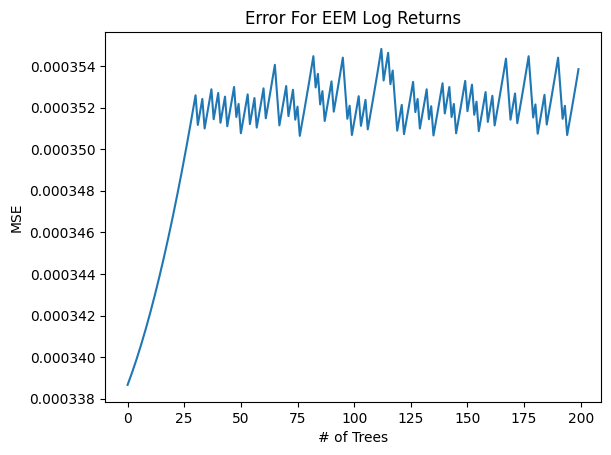

In [28]:
xx = 3
pd.DataFrame(gbv.val_scores_).iloc[:,xx].plot(title="Error For " + train_endog.columns[xx] + " Log Returns", xlabel="# of Trees", ylabel="MSE")


In [16]:
spy = tb.loc[tb["ticker"] == "SPY"]

In [17]:
spy

,ticker,date,open,high,low,close,volume,closeadj,closeunadj,lastupdated,revenue,return,logreturn
7748187,SPY,1997-12-31,96.875,97.625,96.688,97.062,4359500.0,60.957,97.062,2024-05-14,4.231418e+08,NaN,1.711819
7748186,SPY,1998-01-02,97.312,97.656,96.531,97.562,2360900.0,61.271,97.562,2024-05-14,2.303341e+08,1.005151,0.005138
7748185,SPY,1998-01-05,97.844,98.438,96.781,97.781,4191800.0,61.409,97.781,2024-05-14,4.098784e+08,1.002252,0.002250
7748166,SPY,1998-01-06,97.250,97.281,96.188,96.219,3154900.0,60.427,96.219,2024-05-14,3.035613e+08,0.984009,-0.016120
7748165,SPY,1998-01-07,96.094,96.719,95.219,96.469,4424200.0,60.584,96.469,2024-05-14,4.267981e+08,1.002598,0.002595
...,...,...,...,...,...,...,...,...,...,...,...,...,...
193282,SPY,2024-05-13,522.560,522.670,519.740,520.910,36085599.0,520.910,520.910,2024-05-13,1.879735e+10,1.000134,0.000134
749037,SPY,2024-05-14,521.110,523.830,520.560,523.300,56367697.0,523.300,523.300,2024-05-14,2.949722e+10,1.004588,0.004578
10016043,SPY,2024-05-15,525.830,530.080,525.180,529.780,59221426.0,529.780,529.780,2024-05-15,3.137433e+10,1.012383,0.012307
10018897,SPY,2024-05-16,529.880,531.522,528.540,528.690,49268367.0,528.690,528.690,2024-05-16,2.604769e+10,0.997943,-0.002060


In [18]:





# Helper functions for technical indicators (without talib)


def _rsi(close, period):
    """Calculates Relative Strength Index (RSI)."""
    delta = close.diff()
    gain = (delta > 0) * delta
    loss = (delta < 0) * -delta
    avg_gain = gain.rolling(window=period).mean()
    avg_loss = loss.rolling(window=period).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    
    return rsi


def _atr(high, low, close, period):
    """Calculates Average True Range (ATR)."""
    tr1 = pd.Series(high - low)
    tr2 = pd.Series(abs(high - close.shift(1)))
    tr3 = pd.Series(abs(low - close.shift(1)))
    true_range = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
    return true_range.rolling(window=period).mean()


def _adx(high, low, close, period):
    """Calculates Average Directional Index (ADX) and Directional Movement Indicators.

    Args:
      high: Series of high prices.
      low: Series of low prices.
      close: Series of closing prices.
      period: Lookback period for ADX calculation.

    Returns:
      Tuple of pandas Series: (ADX, +DI, -DI)
    """

    upmove = high - high.shift(1)
    downmove = low.shift(1) - low
    plus_dm = pd.Series(np.where((upmove > downmove) & (upmove > 0), upmove, 0))
    minus_dm = pd.Series(np.where((downmove > upmove) & (downmove > 0), downmove, 0))

    tr1 = pd.Series(high - low)
    tr2 = pd.Series(abs(high - close.shift(1)))
    tr3 = pd.Series(abs(low - close.shift(1)))
    true_range = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)

    # Calculate +DI and -DI
    plus_di = 100 * (
        plus_dm.ewm(alpha=1 / period).mean() / true_range.ewm(alpha=1 / period).mean()
    )
    minus_di = 100 * (
        minus_dm.ewm(alpha=1 / period).mean() / true_range.ewm(alpha=1 / period).mean()
    )

    # Calculate DX
    dx = 100 * np.abs(plus_di - minus_di) / (plus_di + minus_di).replace(0, np.inf)

    # Calculate ADX
    adx = dx.ewm(alpha=1 / period).mean().fillna(0)

    return adx, plus_di, minus_di


def _cci(high, low, close, period):
    """Calculates Commodity Channel Index (CCI)."""
    typical_price = (high + low + close) / 3
    ma_typical_price = typical_price.rolling(window=period).mean()
    mean_deviation = (
        pd.Series(abs(typical_price - ma_typical_price)).rolling(window=period).mean()
    )
    cci = (typical_price - ma_typical_price) / (0.015 * mean_deviation)
    return cci


def _cmf(high, low, close, volume, period):
    """Calculates Chaikin Money Flow (CMF)."""
    money_flow = ((close - low) - (high - close)) / (high - low) * volume
    money_flow_volume = money_flow.rolling(window=period).sum()
    volume_sum = volume.rolling(window=period).sum()
    cmf = money_flow_volume / volume_sum
    return cmf


def _aroon(high, low, period):
    """Calculates Aroon Up and Aroon Down.

    Args:
      high: Series of high prices.
      low: Series of low prices.
      period: Lookback period for Aroon calculation.

    Returns:
      Tuple of pandas Series: (Aroon Up, Aroon Down)
    """

    aroon_up = (
        (
            period
            - high.rolling(window=period)
            .apply(lambda x: pd.Series(x).argmax())
            .astype(float)
        )
        / period
        * 100
    )
    aroon_down = (
        (
            period
            - low.rolling(window=period)
            .apply(lambda x: pd.Series(x).argmin())
            .astype(float)
        )
        / period
        * 100
    )

    return aroon_up, aroon_down


def _mfi(high, low, close, volume, period):
    """Calculates Money Flow Index (MFI)."""
    typical_price = (high + low + close) / 3
    money_flow = typical_price * volume

    positive_money_flow = money_flow[close > close.shift(1)]
    negative_money_flow = money_flow[close <= close.shift(1)]

    positive_money_flow = positive_money_flow.rolling(window=period).sum()
    negative_money_flow = abs(negative_money_flow.rolling(window=period).sum())

    money_ratio = positive_money_flow / negative_money_flow
    mfi = 100 - (100 / (1 + money_ratio))

    return mfi


from scipy.stats import percentileofscore


def _pct_rank(data, period):
    """
    Calculates the percentile rank of the current price
    within the last 'period' number of prices.

    Args:
      data: pandas Series containing the price data.
      period: Lookback period for the calculation.

    Returns:
      pandas Series containing the percentile rank.
    """

    percentile_rank = data.rolling(window=period).apply(
        lambda x: percentileofscore(x, x[-1]) / 100, raw=True
    )

    return percentile_rank
    
def _prp(high, low, close, period):
    """
    Calculates the Price Range Percentage.

    Args:
        high: pandas Series of high prices.
        low: pandas Series of low prices.
        close: pandas Series of closing prices.
        period: Lookback period for the calculation.

    Returns:
        pandas Series containing the percentage of the current price 
        within the range of high and low prices over the last 'period' days.
    """

    high_max = high.rolling(window=period).max()
    low_min = low.rolling(window=period).min()
    range_width = high_max - low_min

    price_percentage = (close - low_min) / range_width * 100

    return price_percentage

In [19]:
def calculate_technical_indicators(df):
    """
    Calculates a comprehensive suite of technical indicators for the given OHLCV data.

    Args:
      df: Pandas DataFrame with columns 'open', 'high', 'low', 'close', 'volume'.

    Returns:
      Pandas DataFrame containing the calculated technical indicators.
    """

    df = df.copy()

    # Calculate individual series
    indicators = {}

    # SMA
    for period in [3, 11, 19, 49, 101, 201]:
        indicators[f"SMA_{period}"] = (
            df["close"].rolling(window=period, min_periods=period).mean()
        )
        indicators[f"Log_Ratio_Close_SMA_{period}"] = np.log(
            df["close"] / indicators[f"SMA_{period}"]
        )
        indicators[f"BBO_{period}"] = (df["close"] - indicators[f"SMA_{period}"]) / df[
            "close"
        ].rolling(window=period, min_periods=period).std()

    # RSI for diverse time periods
    for period in [5, 7, 10, 14, 21, 30]:
        indicators[f"RSI_{period}"] = _rsi(df["close"], period)

    # Log Return for different periods
    for period in [11, 22, 44, 88]:
        indicators[f"Log_Return_{period}"] = np.log(
            df["close"] / df["close"].shift(period)
        )
    for period in range(1, 6):
        indicators[f"Log_Return_{period}"] = np.log(
            df["close"] / df["close"].shift(period)
        )

    # Volume Indicators
    indicators["Volume_MA_20"] = df["volume"].rolling(window=20).mean()
    indicators["Volume_Change"] = df["volume"].diff()

    # Volatility Indicators
    indicators["ATR"] = _atr(df["high"], df["low"], df["close"], 14)
    indicators["Log_Returns"] = np.log(df["close"] / df["close"].shift(1))
    indicators["Log_Volatility_20"] = indicators["Log_Returns"].rolling(window=20).std()

    # ADX
#    for adx_period in [14, 20, 28]:
#        (
#            indicators[f"ADX_{adx_period}"],
#            indicators[f"+DI_{adx_period}"],
#            indicators[f"-DI_{adx_period}"],
#        ) = _adx(df["high"], df["low"], df["close"], adx_period)

    # CCI
    for cci_period in [14, 20]:
        indicators[f"CCI_{cci_period}"] = _cci(
            df["high"], df["low"], df["close"], cci_period
        )

    # Chaikin Money Flow
    for cmf_period in [20, 30]:
        indicators[f"CMF_{cmf_period}"] = _cmf(
            df["high"], df["low"], df["close"], df["volume"], cmf_period
        )

    # Aroon (using a period of 25 as an example)
    for aroon_period in [25, 14]:
        (
            indicators[f"Aroon_Up_{aroon_period}"],
            indicators[f"Aroon_Down_{aroon_period}"],
        ) = _aroon(df["high"], df["low"], aroon_period)

    # MFI (using a period of 14 as an example)
    for mfi_period in [14, 20]:
        indicators[f"MFI_{mfi_period}"] = _mfi(
            df["high"], df["low"], df["close"], df["volume"], mfi_period
        )

    # Auto ARIMA Forecast (Example: 30 days for fitting)
    def auto_arima_forecast(data, forecast_horizon=1, window_size=30):
        data = pd.Series(data.values)
        try:
            model = auto_arima(
                data,
                start_p=1,
                start_q=1,
                error_action="ignore",
                seasonal=False,
                suppress_warnings=True,
            )
        except Exception as e:
            print(f"Error fitting Auto ARIMA: {e}")
            return np.nan
        forecast = model.predict(n_periods=forecast_horizon)
        f0 = forecast.values[0]
        dm1 = data.iloc[-1]
        return np.log(f0 / dm1)

    window_size = 30
    
    #indicators[f"Auto_Arima_Forecast_Log_Ratio_{window_size}"] = (
    #    df["close"].rolling(window=window_size).apply(lambda x: auto_arima_forecast(x))
    #)

    # Align and create DataFrame
    aligned_indicators = pd.concat(indicators.values(), axis=1)
    aligned_indicators.columns = [a for a in indicators.keys()]


#    print(indicators)
    
    return aligned_indicators

In [20]:
spy = tb.loc[tb["ticker"] == "SPY"]

In [21]:
tb_in = spy.iloc[-200:].reset_index(drop=True)
ind_in = calculate_technical_indicators(tb_in)
pd.concat([tb_in, ind_in])
ind_in

,SMA_3,Log_Ratio_Close_SMA_3,BBO_3,SMA_11,Log_Ratio_Close_SMA_11,BBO_11,SMA_19,Log_Ratio_Close_SMA_19,BBO_19,SMA_49,...,CCI_14,CCI_20,CMF_20,CMF_30,Aroon_Up_25,Aroon_Down_25,Aroon_Up_14,Aroon_Down_14,MFI_14,MFI_20
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,448.786667,0.004276,0.986048,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,448.756667,-0.000015,-0.003419,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,448.403333,-0.005935,-1.062138,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,520.640000,0.000518,0.660900,512.866364,0.015562,1.056875,508.383684,0.024341,1.515075,512.851837,...,106.628246,92.235940,-0.009113,-0.030832,4.0,68.0,7.142857,92.857143,NaN,NaN
196,521.683333,0.003094,1.154340,514.070000,0.017795,1.132462,509.581053,0.026566,1.575802,513.180816,...,100.770330,95.938102,0.045072,-0.044637,4.0,72.0,7.142857,100.000000,NaN,NaN
197,524.663333,0.009705,1.114871,516.597273,0.025198,1.581676,511.173684,0.035752,1.959536,513.589592,...,127.697368,125.576975,0.125919,-0.020075,4.0,76.0,7.142857,71.428571,NaN,NaN
198,527.256667,0.002715,0.413107,519.173636,0.018164,1.340584,512.938421,0.030246,1.663397,513.872857,...,111.631547,122.472991,0.131425,0.003319,4.0,80.0,7.142857,78.571429,NaN,NaN
